In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Visual analysis of feature importance

## Create data

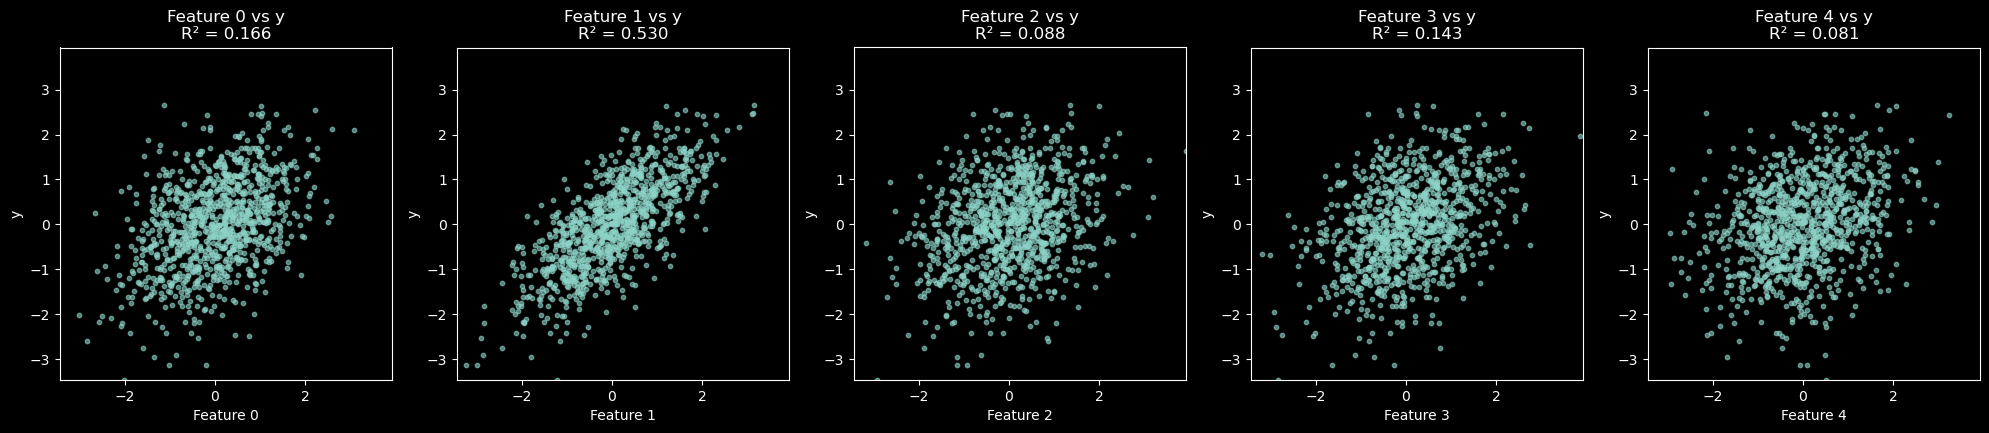

In [3]:
from sklearn import datasets
from sklearn.metrics import r2_score

n_feat = 5

X, y = datasets.make_regression(
    n_samples=1000,
    n_features=n_feat,
    noise=1,
    random_state=42
)

# normalize
X -= X.mean()
X /= X.std()
y -= y.mean()
y /= y.std()

# Determine common limits for all axes
x_min = min(X[:, i].min() for i in range(n_feat))
x_max = max(X[:, i].max() for i in range(n_feat))
y_min = y.min()
y_max = y.max()

xy_min = min(x_min, y_min)
xy_max = max(x_max, y_max)

# Plot settings
n_cols = 5
n_rows = int(np.ceil(n_feat / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))
axes = axes.flatten()

# Scatter plot for each feature vs y with R² and equal aspect/limits
for i in range(n_feat):
    r = np.corrcoef(X[:, i], y)[0, 1]
    r2 = r ** 2

    axes[i].scatter(X[:, i], y, s=10, alpha=0.6)
    axes[i].set_title(f'Feature {i} vs y\nR² = {r2:.3f}')
    axes[i].set_xlabel(f'Feature {i}')
    axes[i].set_ylabel('y')
    axes[i].set_xlim(xy_min, xy_max)
    axes[i].set_ylim(xy_min, xy_max)
    axes[i].set_aspect('equal')

# Hide any unused subplots
for i in range(n_feat, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Fit models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
dt = DecisionTreeRegressor(random_state=42)

rf.fit(X, y)
gb.fit(X, y)
dt.fit(X, y)

# Extract feature importances
rf_importance = rf.feature_importances_
gb_importance = gb.feature_importances_
dt_importance = dt.feature_importances_

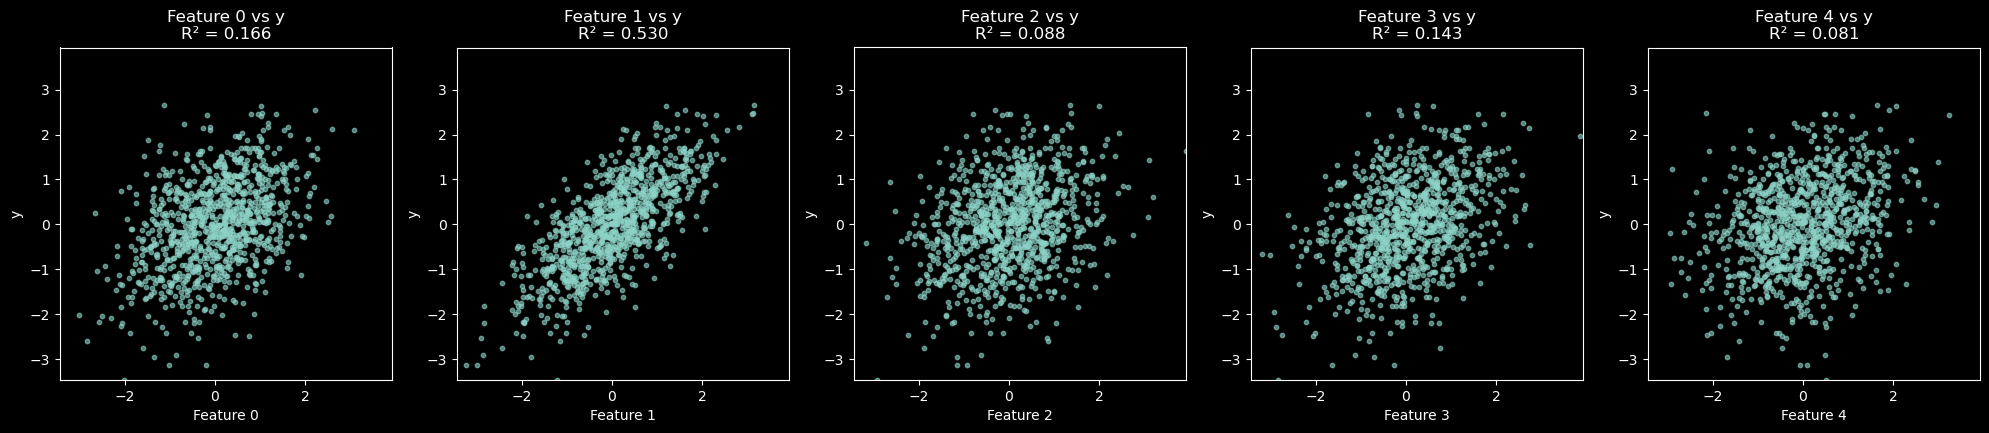

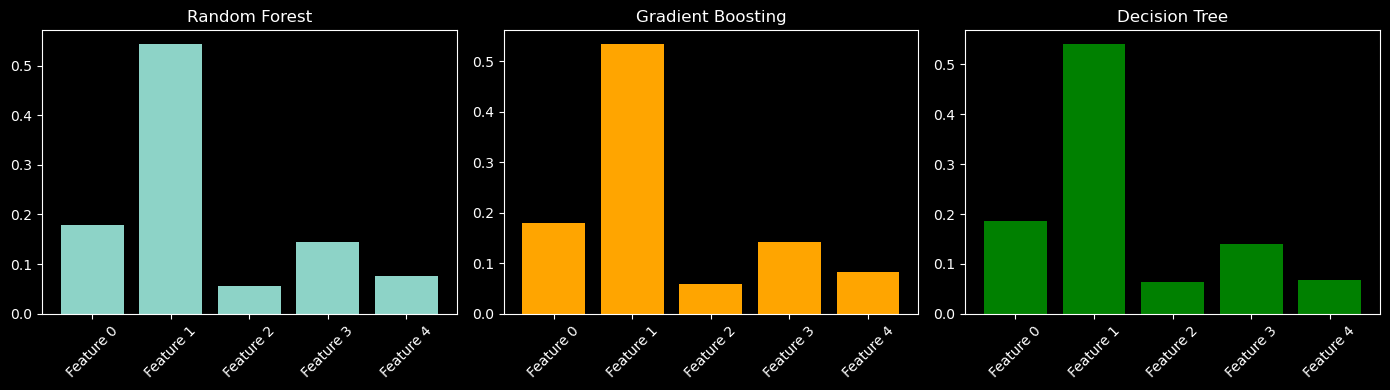

In [5]:
# Plot settings
n_cols = 5
n_rows = int(np.ceil(n_feat / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))
axes = axes.flatten()

# Scatter plot for each feature vs y with R² and equal aspect/limits
for i in range(n_feat):
    r = np.corrcoef(X[:, i], y)[0, 1]
    r2 = r ** 2

    axes[i].scatter(X[:, i], y, s=10, alpha=0.6)
    axes[i].set_title(f'Feature {i} vs y\nR² = {r2:.3f}')
    axes[i].set_xlabel(f'Feature {i}')
    axes[i].set_ylabel('y')
    axes[i].set_xlim(xy_min, xy_max)
    axes[i].set_ylim(xy_min, xy_max)
    axes[i].set_aspect('equal')

# Hide any unused subplots
for i in range(n_feat, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

###################

# Plot feature importances
feature_names = [f"Feature {i}" for i in range(n_feat)]
x = np.arange(n_feat)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(x, rf_importance)
plt.xticks(x, feature_names, rotation=45)
plt.title("Random Forest")

plt.subplot(1, 3, 2)
plt.bar(x, gb_importance, color='orange')
plt.xticks(x, feature_names, rotation=45)
plt.title("Gradient Boosting")

plt.subplot(1, 3, 3)
plt.bar(x, dt_importance, color='green')
plt.xticks(x, feature_names, rotation=45)
plt.title("Decision Tree")

plt.tight_layout()
plt.show()

# Modeling

Can we remove the bad features without harming performance?

## Create data

In [15]:
n_feat = 50

X, y = datasets.make_regression(
    n_samples=700,
    n_features=n_feat,
    noise=50,
    random_state=42
)

In [16]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

## Get importances

In [17]:
# Train models
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
gb = GradientBoostingRegressor(n_estimators=100, max_depth=2)
dt = DecisionTreeRegressor(max_depth=5)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
dt.fit(X_train, y_train)

# Get feature importances
rf_importance = rf.feature_importances_
gb_importance = gb.feature_importances_
dt_importance = dt.feature_importances_

# Argsort importances (from most to least important)
rf_sorted_indices = np.argsort(-rf_importance)
gb_sorted_indices = np.argsort(-gb_importance)
dt_sorted_indices = np.argsort(-dt_importance)

In [18]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# Store R2 scores
rf_train_r2 = []
rf_test_r2 = []
gb_train_r2 = []
gb_test_r2 = []
dt_train_r2 = []
dt_test_r2 = []

# Loop over top k features
for k in tqdm(range(1, n_feat + 1), ncols=50):
    # Random Forest
    rf.fit(X_train[:, rf_sorted_indices[:k]], y_train)
    rf_train_r2.append(r2_score(y_train, rf.predict(X_train[:, rf_sorted_indices[:k]])))
    rf_test_r2.append(r2_score(y_test, rf.predict(X_test[:, rf_sorted_indices[:k]])))

    # Gradient Boosting
    gb.fit(X_train[:, gb_sorted_indices[:k]], y_train)
    gb_train_r2.append(r2_score(y_train, gb.predict(X_train[:, gb_sorted_indices[:k]])))
    gb_test_r2.append(r2_score(y_test, gb.predict(X_test[:, gb_sorted_indices[:k]])))

    # Decision Tree
    dt.fit(X_train[:, dt_sorted_indices[:k]], y_train)
    dt_train_r2.append(r2_score(y_train, dt.predict(X_train[:, dt_sorted_indices[:k]])))
    dt_test_r2.append(r2_score(y_test, dt.predict(X_test[:, dt_sorted_indices[:k]])))

100%|█████████████| 50/50 [00:35<00:00,  1.40it/s]


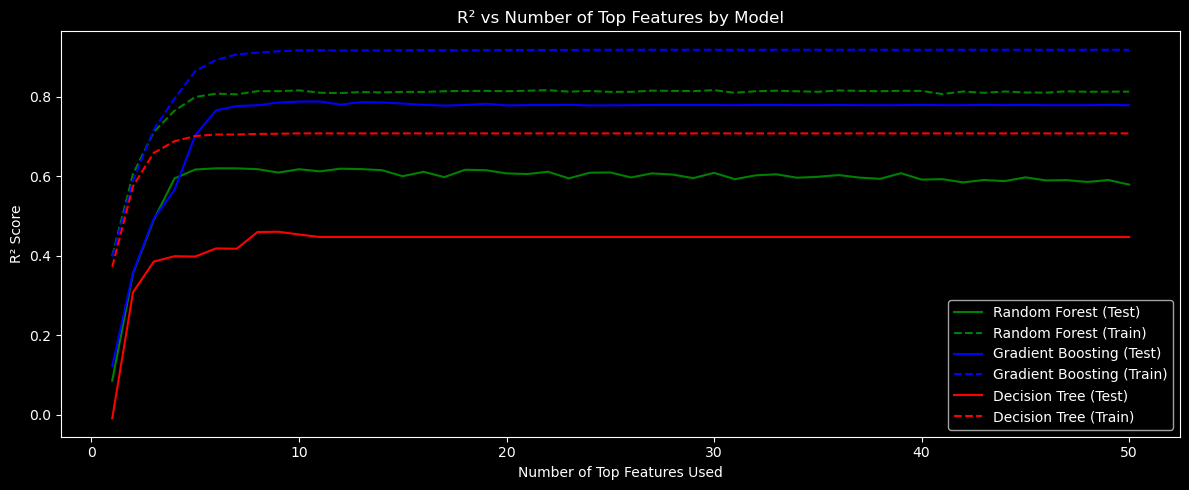

In [19]:
# Plotting
x = np.arange(1, n_feat + 1)
plt.figure(figsize=(12, 5))

# Random Forest (green)
plt.plot(x, rf_test_r2, color='green', label='Random Forest (Test)')
plt.plot(x, rf_train_r2, color='green', linestyle='--', label='Random Forest (Train)')

# Gradient Boosting (blue)
plt.plot(x, gb_test_r2, color='blue', label='Gradient Boosting (Test)')
plt.plot(x, gb_train_r2, color='blue', linestyle='--', label='Gradient Boosting (Train)')

# Decision Tree (red)
plt.plot(x, dt_test_r2, color='red', label='Decision Tree (Test)')
plt.plot(x, dt_train_r2, color='red', linestyle='--', label='Decision Tree (Train)')

plt.xlabel("Number of Top Features Used")
plt.ylabel("R² Score")
plt.title("R² vs Number of Top Features by Model")
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

Note in above that peak r2 isn't necessarily achieved with the most features, just like with Lasso regression.

## Using linear regression on important features

In [20]:
from sklearn.linear_model import LinearRegression

# Initialize linear regression model
lr = LinearRegression()

# Store R² scores for Linear Regression
lr_rf_train_r2 = []
lr_rf_test_r2 = []
lr_gb_train_r2 = []
lr_gb_test_r2 = []
lr_dt_train_r2 = []
lr_dt_test_r2 = []

# Loop over top k features
for k in tqdm(range(1, n_feat + 1), ncols=50):
    # LR on RF features
    lr.fit(X_train[:, rf_sorted_indices[:k]], y_train)
    lr_rf_train_r2.append(r2_score(y_train, lr.predict(X_train[:, rf_sorted_indices[:k]])))
    lr_rf_test_r2.append(r2_score(y_test, lr.predict(X_test[:, rf_sorted_indices[:k]])))

    # LR on GB features
    lr.fit(X_train[:, gb_sorted_indices[:k]], y_train)
    lr_gb_train_r2.append(r2_score(y_train, lr.predict(X_train[:, gb_sorted_indices[:k]])))
    lr_gb_test_r2.append(r2_score(y_test, lr.predict(X_test[:, gb_sorted_indices[:k]])))

    # LR on DT features
    lr.fit(X_train[:, dt_sorted_indices[:k]], y_train)
    lr_dt_train_r2.append(r2_score(y_train, lr.predict(X_train[:, dt_sorted_indices[:k]])))
    lr_dt_test_r2.append(r2_score(y_test, lr.predict(X_test[:, dt_sorted_indices[:k]])))

100%|████████████| 50/50 [00:00<00:00, 197.38it/s]


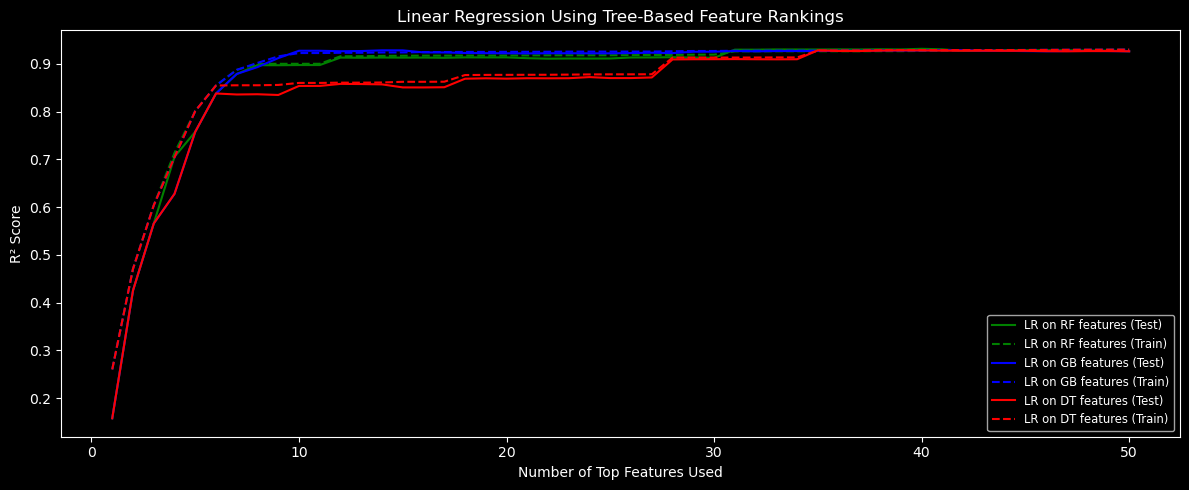

In [21]:
# Plotting Linear Regression results using original color scheme
x = np.arange(1, n_feat + 1)
plt.figure(figsize=(12, 5))

# LR on RF-ranked features (green)
plt.plot(x, lr_rf_test_r2, color='green', label='LR on RF features (Test)')
plt.plot(x, lr_rf_train_r2, '--', color='green', label='LR on RF features (Train)')

# LR on GB-ranked features (blue)
plt.plot(x, lr_gb_test_r2, color='blue', label='LR on GB features (Test)')
plt.plot(x, lr_gb_train_r2, '--', color='blue', label='LR on GB features (Train)')

# LR on DT-ranked features (red)
plt.plot(x, lr_dt_test_r2, color='red', label='LR on DT features (Test)')
plt.plot(x, lr_dt_train_r2, '--', color='red', label='LR on DT features (Train)')

plt.xlabel("Number of Top Features Used")
plt.ylabel("R² Score")
plt.title("Linear Regression Using Tree-Based Feature Rankings")
plt.legend(loc='lower right', fontsize='small')
#plt.grid(True)
plt.tight_layout()
plt.show()